In [1]:
import pandas as pd
import altair as alt
import pandas as pd
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T 
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import warnings
warnings.filterwarnings('ignore')


In [2]:
# initialize sparkSession
spark = SparkSession.builder.config("spark.executor.memory","12g").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [3]:
spark.catalog.clearCache()

In [4]:
file_names_range = list(range(2009, 2016))
file_paths = [f'{file}.csv' for file in file_names_range]

In [5]:
schema = T.StructType([
    T.StructField("FL_DATE", T.TimestampType(), nullable=True),
    T.StructField("OP_CARRIER", T.StringType(), nullable=True),
    T.StructField("OP_CARRIER_FL_NUM", T.IntegerType(), nullable=True),
    T.StructField("ORIGIN", T.StringType(), nullable=True),
    T.StructField("DEST", T.StringType(), nullable=True),
    T.StructField("CRS_DEP_TIME", T.DoubleType(), nullable=True),
    T.StructField("DEP_TIME", T.DoubleType(), nullable=True),
    T.StructField("DEP_DELAY", T.DoubleType(), nullable=True),
    T.StructField("TAXI_OUT", T.DoubleType(), nullable=True),
    T.StructField("WHEELS_OFF", T.DoubleType(), nullable=True),
    T.StructField("WHEELS_ON", T.DoubleType(), nullable=True),
    T.StructField("TAXI_IN", T.DoubleType(), nullable=True),
    T.StructField("CRS_ARR_TIME", T.DoubleType(), nullable=True),
    T.StructField("ARR_TIME",T.DoubleType(), nullable=True),
    T.StructField("ARR_DELAY", T.DoubleType(), nullable=True),
    T.StructField("CANCELLED", T.DoubleType(), nullable=True),
    T.StructField("CANCELLATION_CODE", T.StringType(), nullable=True),
    T.StructField("DIVERTED", T.DoubleType(), nullable=True),
    T.StructField("CRS_ELAPSED_TIME", T.DoubleType(), nullable=True),
    T.StructField("ACTUAL_ELAPSED_TIME", T.DoubleType(), nullable=True),
    T.StructField("AIR_TIME", T.DoubleType(), nullable=True),
    T.StructField("DISTANCE", T.DoubleType(), nullable=True),
    T.StructField("CARRIER_DELAY", T.DoubleType(), nullable=True),
    T.StructField("WEATHER_DELAY", T.DoubleType(), nullable=True),
    T.StructField("NAS_DELAY", T.DoubleType(), nullable=True),
    T.StructField("SECURITY_DELAY", T.DoubleType(), nullable=True),
    T.StructField("LATE_AIRCRAFT_DELAY", T.DoubleType(), nullable=True),
    T.StructField("Unnamed: 27", T.StringType(), nullable=True)
])

In [6]:
df = spark.read.schema(schema).format("csv").option("header", "true").load(file_paths)

## Preprocessing

In [7]:
# Create a list of expressions to count nulls in each column
null_counts_expressions = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]

# Aggregate the null counts using select and the list of expressions
null_counts_df = df.select(null_counts_expressions)

# Collect the results to the driver
null_counts = null_counts_df.collect()[0]

# Prepare to print the results
null_counts_dict = {df.columns[i]: null_counts[i] for i in range(len(df.columns))}

# Print the null counts for each column
for column, count in null_counts_dict.items():
    print(f"{column}: {count}")

FL_DATE: 0
OP_CARRIER: 0
OP_CARRIER_FL_NUM: 0
ORIGIN: 0
DEST: 0
CRS_DEP_TIME: 1
DEP_TIME: 679642
DEP_DELAY: 679642
TAXI_OUT: 700508
WHEELS_OFF: 700508
WHEELS_ON: 725252
TAXI_IN: 725251
CRS_ARR_TIME: 2
ARR_TIME: 725252
ARR_DELAY: 809587
CANCELLED: 0
CANCELLATION_CODE: 42343168
DIVERTED: 0
CRS_ELAPSED_TIME: 37
ACTUAL_ELAPSED_TIME: 809588
AIR_TIME: 809587
DISTANCE: 0
CARRIER_DELAY: 35006921
WEATHER_DELAY: 35006921
NAS_DELAY: 35006921
SECURITY_DELAY: 35006921
LATE_AIRCRAFT_DELAY: 35006921
Unnamed: 27: 43051239


In [8]:
# remove null values from the cols used for classification:
df = df.dropna(subset= [
    'FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'CRS_ARR_TIME',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'DISTANCE'])

# save df for analysis
analysis_df = df

In [9]:
# drop the cols who indirectly indicate if a flight is canelled or not (apart from the column CANCELLED)
# most of those cols contain null values, if the flight is cancelled

classify_df = df.drop("Unnamed: 27", 
                        "CARRIER_DELAY", 
                        "WEATHER_DELAY",
                        "NAS_DELAY",
                        "SECURITY_DELAY",
                        "LATE_AIRCRAFT_DELAY",
                        "CANCELLATION_CODE",
                        "DEP_TIME",
                        "DEP_DELAY",
                        "TAXI_OUT",
                        "WHEELS_OFF",
                        "WHEELS_ON",
                        "TAXI_IN",
                        "ARR_TIME",
                        "ARR_DELAY",
                        "ACTUAL_ELAPSED_TIME", 
                        "AIR_TIME")

In [10]:
df.show()

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|            FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------

In [11]:
# numerical timestamp column
classify_df = classify_df.withColumn("FL_DATE", F.year("FL_DATE"))

In [12]:
classify_df.columns

['FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'CRS_ARR_TIME',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'DISTANCE']

Number of not cancelled flights: 42343151
Number of cancelled flights: 708050


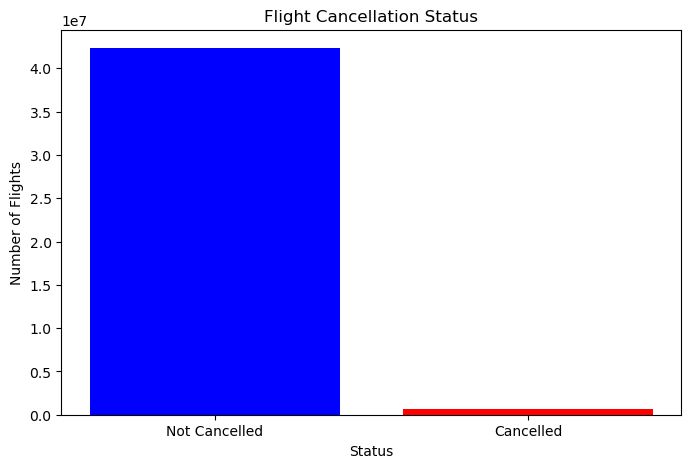

In [13]:
import matplotlib.pyplot as plt

from pyspark.sql.functions import col

# Count the number of flights that were not cancelled (CANCELLED = 0)
not_cancelled_count = df.filter(col("CANCELLED") == 0).count()

# Count the number of flights that were cancelled (CANCELLED = 1)
cancelled_count = df.filter(col("CANCELLED") == 1).count()

print("Number of not cancelled flights:", not_cancelled_count)
print("Number of cancelled flights:", cancelled_count)

# Plotting the results
labels = ['Not Cancelled', 'Cancelled']
counts = [not_cancelled_count, cancelled_count]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['blue', 'red'])
plt.title('Flight Cancellation Status')
plt.xlabel('Status')
plt.ylabel('Number of Flights')
plt.show()

In [14]:
# Balancing the dataset with improved efficiency
pos_df = classify_df.filter(F.col('CANCELLED') == 1)
neg_df = classify_df.filter(F.col('CANCELLED') == 0)
pos_count = pos_df.count()  # Compute count only once
neg_count = neg_df.count()  # Compute count only once
sample_ratio = pos_count / neg_count
balanced_neg_df = neg_df.sample(withReplacement=False, fraction=sample_ratio)
classify_df = pos_df.union(balanced_neg_df)


Number of balanced not cancelled flights: 708696
Number of balanced cancelled flights: 708050


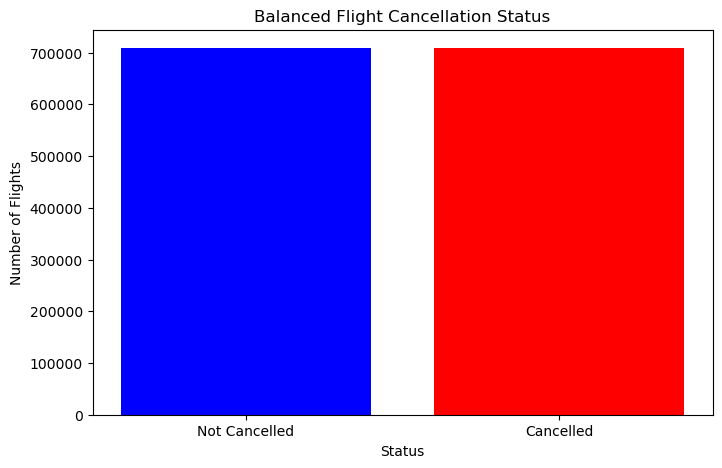

In [15]:
# Count the balanced data
balanced_pos_count = classify_df.filter(col("CANCELLED") == 1).count()
balanced_neg_count = classify_df.filter(col("CANCELLED") == 0).count()

# Print the counts
print("Number of balanced not cancelled flights:", balanced_neg_count)
print("Number of balanced cancelled flights:", balanced_pos_count)

# Plotting the balanced data
labels = ['Not Cancelled', 'Cancelled']
counts = [balanced_neg_count, balanced_pos_count]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['blue', 'red'])
plt.title('Balanced Flight Cancellation Status')
plt.xlabel('Status')
plt.ylabel('Number of Flights')
plt.show()

In [16]:
classify_df.show()

+-------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+
|FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|DISTANCE|
+-------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+
|   2009|        YV|             7104|   DEN| CPR|      2150.0|      2312.0|      1.0|     0.0|            82.0|   230.0|
|   2009|        YV|             7329|   DTW| ORD|      1857.0|      1914.0|      1.0|     0.0|            77.0|   235.0|
|   2009|        YV|             7065|   EWR| IAD|      1013.0|      1139.0|      1.0|     0.0|            86.0|   213.0|
|   2009|        YV|             2984|   FAT| LAS|       710.0|       820.0|      1.0|     0.0|            70.0|   258.0|
|   2009|        YV|             2823|   FAT| PHX|       920.0|      1205.0|      1.0|     0.0|           105.0|   493.0|
|   2009|        YV|    

In [17]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Create StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_Index") for col in ["OP_CARRIER", "ORIGIN", "DEST"]]

# Create OneHotEncoder for indexed columns
encoders = [OneHotEncoder(inputCol=col+"_Index", outputCol=col+"_vec") for col in ["OP_CARRIER", "ORIGIN", "DEST"]]

# Define the stages in the pipeline
stages = indexers + encoders

# Create a pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the data
transformed_df = pipeline.fit(classify_df).transform(classify_df)

# Show the transformed DataFrame
transformed_df.show()


+-------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+----------------+------------+----------+---------------+-----------------+-----------------+
|FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|DISTANCE|OP_CARRIER_Index|ORIGIN_Index|DEST_Index| OP_CARRIER_vec|       ORIGIN_vec|         DEST_vec|
+-------+----------+-----------------+------+----+------------+------------+---------+--------+----------------+--------+----------------+------------+----------+---------------+-----------------+-----------------+
|   2009|        YV|             7104|   DEN| CPR|      2150.0|      2312.0|      1.0|     0.0|            82.0|   230.0|            12.0|         3.0|     203.0|(20,[12],[1.0])|  (344,[3],[1.0])|(344,[203],[1.0])|
|   2009|        YV|             7329|   DTW| ORD|      1857.0|      1914.0|      1.0|     0.0|            77.0|   235.0|            12.0|  

In [18]:
from pyspark.ml.feature import VectorAssembler

# Create a copy of the column list to safely modify it
feature_columns = transformed_df.columns[:]

# Columns to be excluded from features
excluded_columns = ["CANCELLED", "ORIGIN", "DEST", "OP_CARRIER", "OP_CARRIER_Index", "ORIGIN_Index", "DEST_Index"]

# Remove columns that should not be in our feature columns (label column, intermediate preprocessing columns)
feature_columns = [col for col in feature_columns if col not in excluded_columns]

# Create VectorAssembler with a list of feature columns and a target output column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

# Transform the DataFrame to assemble features
assembled_df = assembler.transform(transformed_df)

# Show the first few rows of the assembled DataFrame
assembled_df.select("features").show(truncate=False)

+-----------------------------------------------------------------------------------+
|features                                                                           |
+-----------------------------------------------------------------------------------+
|(715,[0,1,2,3,5,6,19,30,574],[2009.0,7104.0,2150.0,2312.0,82.0,230.0,1.0,1.0,1.0]) |
|(715,[0,1,2,3,5,6,19,39,371],[2009.0,7329.0,1857.0,1914.0,77.0,235.0,1.0,1.0,1.0]) |
|(715,[0,1,2,3,5,6,19,33,392],[2009.0,7065.0,1013.0,1139.0,86.0,213.0,1.0,1.0,1.0]) |
|(715,[0,1,2,3,5,6,19,125,387],[2009.0,2984.0,710.0,820.0,70.0,258.0,1.0,1.0,1.0])  |
|(715,[0,1,2,3,5,6,19,125,380],[2009.0,2823.0,920.0,1205.0,105.0,493.0,1.0,1.0,1.0])|
|(715,[0,1,2,3,5,6,19,144,371],[2009.0,7344.0,600.0,658.0,58.0,139.0,1.0,1.0,1.0])  |
|(715,[0,1,2,3,5,6,19,113,380],[2009.0,2798.0,600.0,920.0,140.0,455.0,1.0,1.0,1.0]) |
|(715,[0,1,2,3,5,6,19,113,380],[2009.0,2939.0,940.0,1214.0,94.0,455.0,1.0,1.0,1.0]) |
|(715,[0,1,2,3,5,6,9,28,496],[2009.0,4537.0,1215.0,122

In [19]:
# select only feature and label column
final_classify_df = assembled_df.select("features", F.col("CANCELLED").alias("label"))
final_classify_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
|(715,[0,1,2,3,5,6...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [20]:
final_classify_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



## Training Models

In [21]:
train, test = final_classify_df.randomSplit([.7, .3], seed=9)

In [22]:
#spark.catalog.clearCache()
# caching data into memory - models run quicker
train = train.repartition(32).cache()
test = test.repartition(32).cache()

### LOGISITIC REGRESSION 

In [23]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define your logistic regression model
log_regress = LogisticRegression(featuresCol='features', labelCol='label')

# Fit the logistic regression model on the training data
log_regress_model = log_regress.fit(train)

# Make predictions on the test data
predictions = log_regress_model.transform(test)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Print the classification report
from sklearn.metrics import classification_report

y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

print(classification_report(y_true, y_pred))

Accuracy: 0.6535133776396436
              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65    212898
         1.0       0.65      0.66      0.65    212775

    accuracy                           0.65    425673
   macro avg       0.65      0.65      0.65    425673
weighted avg       0.65      0.65      0.65    425673



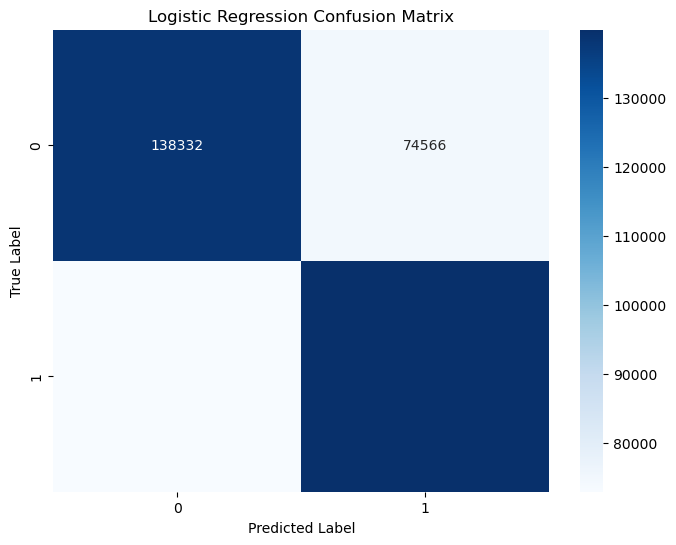

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix_logreg = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix using matplotlib and seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

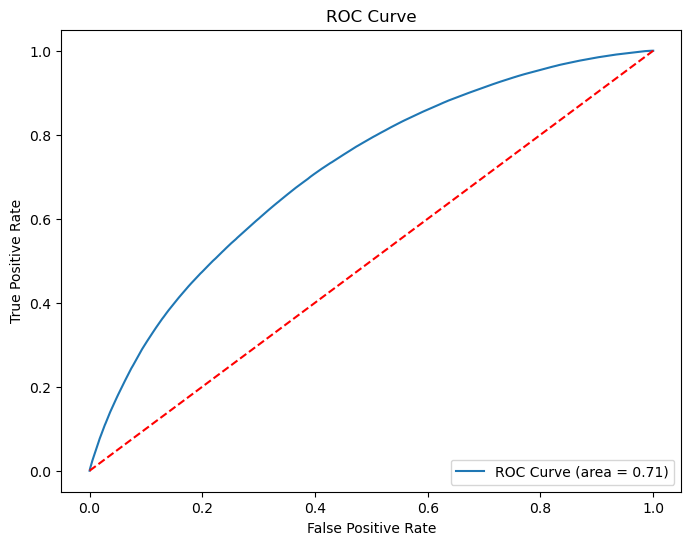

ROC AUC on test data: 0.712139047603286


In [25]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Obtain the summary object for the trained model which contains the ROC data
training_summary = log_regress_model.summary

# Get the ROC object from the training summary
roc = training_summary.roc.toPandas()

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve (area = %0.2f)' % training_summary.areaUnderROC)
plt.plot([0, 1], [0, 1], 'r--')  # Dashed diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# You can also evaluate the model on a test set
predictions = log_regress_model.transform(test)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC on test data: {roc_auc}')


### RANDOMN FOREST

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define your logistic regression model
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='label')

# Fit the model on the training data
rf_model = rf_classifier.fit(train)

# Make predictions on the test data
predictions = rf_model.transform(test)

# Evaluate the model's performance using PySpark
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Evaluate the model using sklearn's classification_report
# Convert Spark DataFrame to Pandas DataFrame for sklearn compatibility
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

# Print the classification report
print(classification_report(y_true, y_pred))

Accuracy: 0.6194261792502695
              precision    recall  f1-score   support

         0.0       0.61      0.66      0.63    212898
         1.0       0.63      0.58      0.60    212775

    accuracy                           0.62    425673
   macro avg       0.62      0.62      0.62    425673
weighted avg       0.62      0.62      0.62    425673



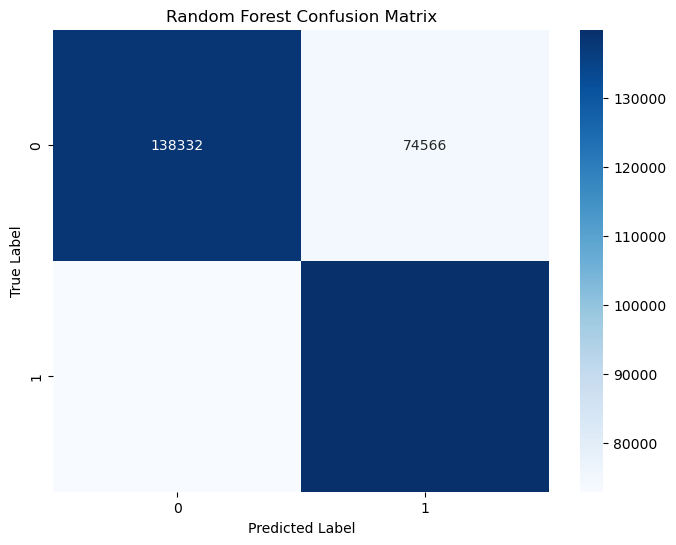

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix_rf = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix using matplotlib and seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

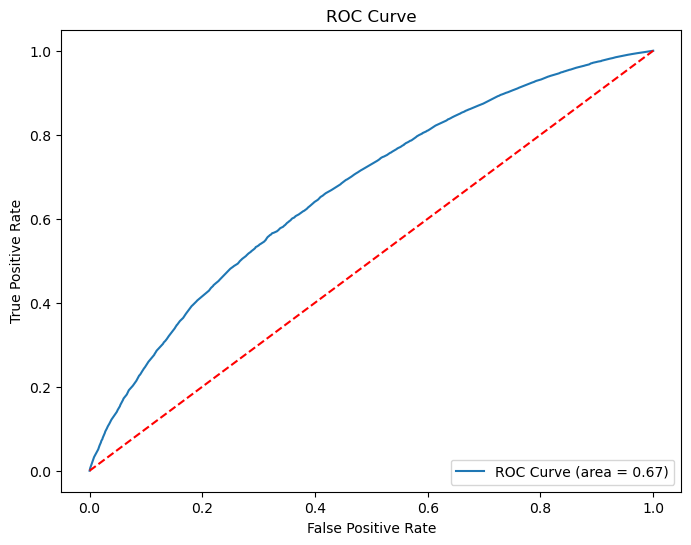

ROC AUC on test data: 0.669451769948877


In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Obtain the summary object for the trained model which contains the ROC data
training_summary = rf_model.summary

# Get the ROC object from the training summary
roc = training_summary.roc.toPandas()

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve (area = %0.2f)' % training_summary.areaUnderROC)
plt.plot([0, 1], [0, 1], 'r--')  # Dashed diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# You can also evaluate the model on a test set
predictions = rf_model.transform(test)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC on test data: {roc_auc}')


### DECISION TREE CLASSIFIER


Decision Tree Accuracy: 0.6173024833616414
Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.63      0.62    212898
         1.0       0.62      0.61      0.61    212775

    accuracy                           0.62    425673
   macro avg       0.62      0.62      0.62    425673
weighted avg       0.62      0.62      0.62    425673

Confusion Matrix:


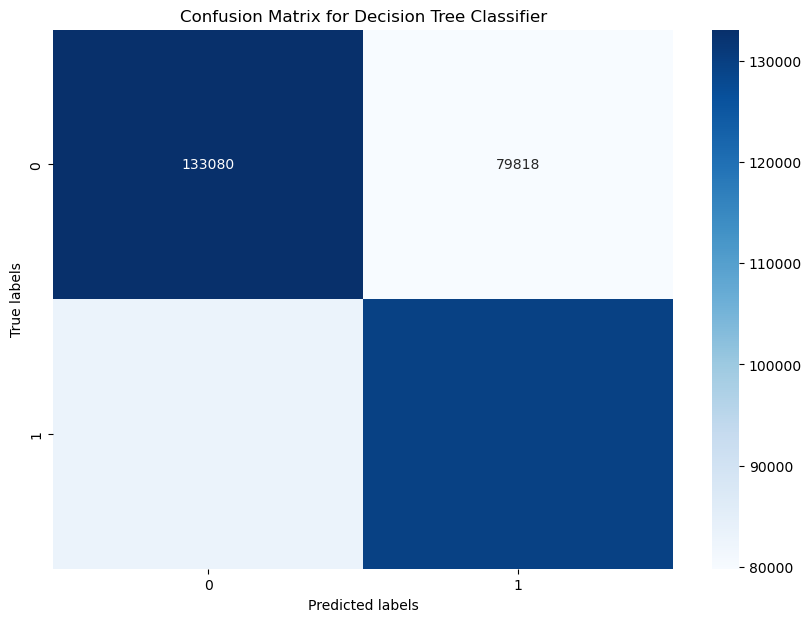

In [29]:
# Assume 'train' and 'test' DataFrames are already defined

# Define the Decision Tree model
dt_classifier = DecisionTreeClassifier(featuresCol='features', labelCol='label')

# Fit the model on the training data
dt_model = dt_classifier.fit(train)

# Make predictions on the test data
dt_predictions = dt_model.transform(test)

# Evaluate the Decision Tree performance using PySpark
dt_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
dt_accuracy = dt_evaluator.evaluate(dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)

# Convert Spark DataFrame to Pandas DataFrame for sklearn compatibility
dt_y_true = dt_predictions.select("label").toPandas()
dt_y_pred = dt_predictions.select("prediction").toPandas()

# Print the classification report for Decision Tree
print("Decision Tree Classification Report:")
print(classification_report(dt_y_true, dt_y_pred))

# Generate and print the confusion matrix
cm = confusion_matrix(dt_y_true, dt_y_pred)
print("Confusion Matrix:")

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

### GRADIENT BOOSTING ALGORITHM 

Gradient Boosting Tree Accuracy: 0.6402050400189817
Gradient Boosting Tree Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.65      0.65    212898
         1.0       0.64      0.63      0.64    212775

    accuracy                           0.64    425673
   macro avg       0.64      0.64      0.64    425673
weighted avg       0.64      0.64      0.64    425673

Confusion Matrix for Gradient Boosting Tree:


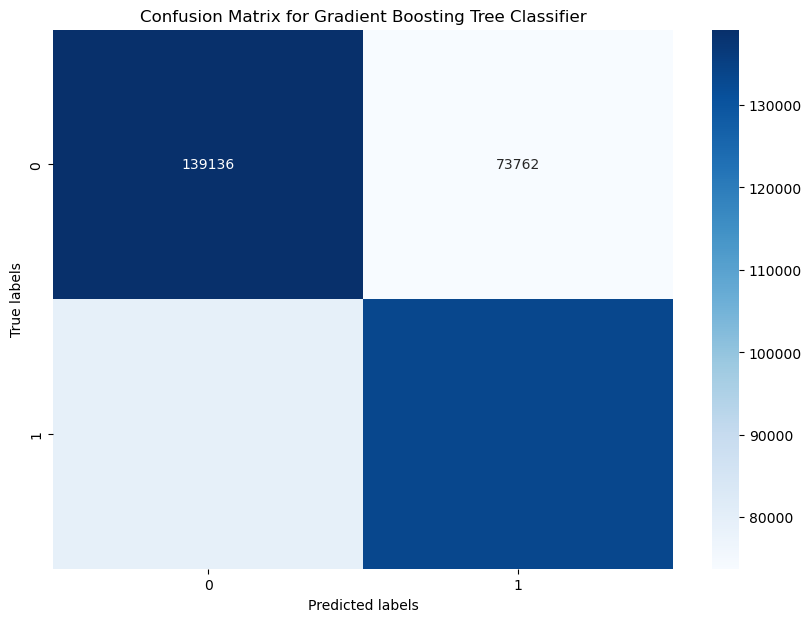

In [30]:
from pyspark.ml.classification import GBTClassifier

# Define the Gradient Boosting Tree model
gbt_classifier = GBTClassifier(featuresCol='features', labelCol='label')

# Fit the model on the training data
gbt_model = gbt_classifier.fit(train)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test)

# Evaluate the Gradient Boosting Tree performance using PySpark
gbt_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
gbt_accuracy = gbt_evaluator.evaluate(gbt_predictions)
print("Gradient Boosting Tree Accuracy:", gbt_accuracy)

# Convert Spark DataFrame to Pandas DataFrame for sklearn compatibility
gbt_y_true = gbt_predictions.select("label").toPandas()
gbt_y_pred = gbt_predictions.select("prediction").toPandas()

# Print the classification report for Gradient Boosting Tree
print("Gradient Boosting Tree Classification Report:")
print(classification_report(gbt_y_true, gbt_y_pred))

# Generate and print the confusion matrix for GBT
gbt_cm = confusion_matrix(gbt_y_true, gbt_y_pred)
print("Confusion Matrix for Gradient Boosting Tree:")

# Plotting the confusion matrix for Gradient Boosting Tree
plt.figure(figsize=(10, 7))
sns.heatmap(gbt_cm, annot=True, fmt='g', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Gradient Boosting Tree Classifier')
plt.show()
